# Test data for locomotion activity recognition

### 1) Workspace preparation

In [1]:
import importlib
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LocomotionAnalysisTools as lat

In [2]:
# Reload import if modified (jupyter notebook caches imports by default)
importlib.reload(lat)

<module 'LocomotionAnalysisTools' from 'C:\\Users\\robaeten\\OneDrive - UGent\\Documenten\\Werk\\python\\GMC_GPR_GDA\\LocomotionAnalysisTools.py'>

### 2) Data preparation

In [101]:
# Define where to get the data
dataFolder = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data"

# subjectSessions = {"Subject1": ["Session4"]}
# subjectSessions = {"Subject2": ["Session1"]}
# subjectSessions = {"Subject3": ["Session1"]}
# subjectSessions = {"Subject4": ["Session1"]}
# subjectSessions = {"Subject5": ["Session1"]}
# subjectSessions = {"Subject6": ["Session1"]}
# subjectSessions = {"Subject7": ["Session1"]}
# subjectSessions = {"Subject8": ["Session1"]}
# subjectSessions = {"Subject9": ["Session1"]}
# subjectSessions = {"Subject10": ["Session1"]}
# subjectSessions = {"Subject11": ["Session1"]}
# subjectSessions = {"Subject12": ["Session1"]}
# subjectSessions = {"Subject13": ["Session1"]}
# subjectSessions = {"Subject14": ["Session1"]}
# subjectSessions = {"Subject15": ["Session1"]}
# subjectSessions = {"Subject16": ["Session1"]}
# subjectSessions = {"Subject17": ["Session1"]}
# subjectSessions = {"Subject18": ["Session1"]}
# subjectSessions = {"Subject19": ["Session1"]}
subjectSessions = {"Subject20": ["Session1"]}

dataToRead = "_Proc_Trn"
foldersToRead, subjectInfoFiles = lat.get_data_locations(dataFolder, subjectSessions, dataToRead)

# Get list of tuples with every file to read and its corresponding activity, as well as a list with corresponding subject information
filesToRead, subjectInfo = lat.get_filenames_train(foldersToRead, subjectInfoFiles, test_data=True)

# Define which leg is instrumented with EMG
instrumented_leg = "right"

### 3) Construct test data

[110, 224, 335, 449, 563]
[160, 214, 234, 315, 385, 439, 459, 533]


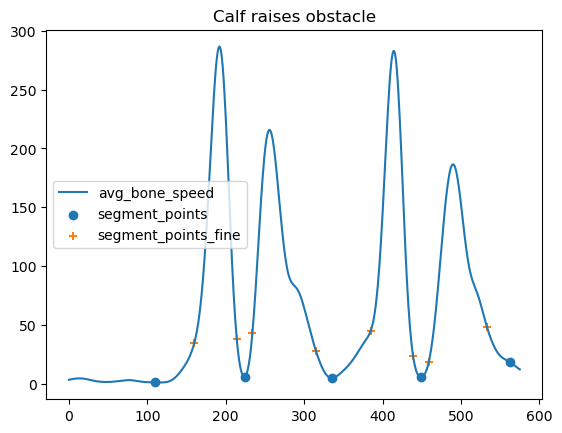

[77, 222, 367, 507, 652]
[107, 211, 240, 357, 372, 487, 527, 632]


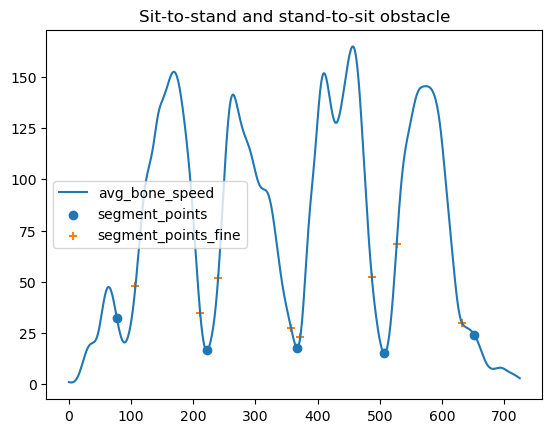

[141, 274, 407, 529, 662]
[153, 268, 278, 392, 416, 513, 539, 648]


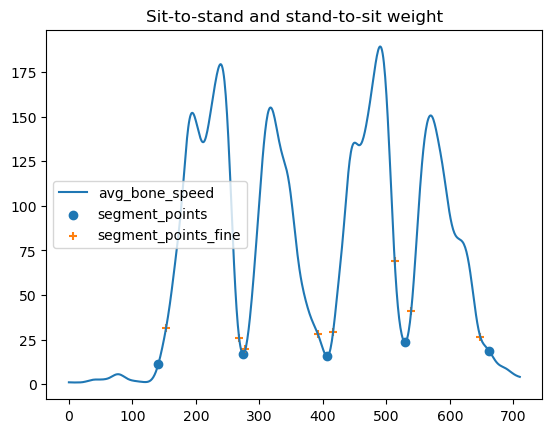

[93, 194, 295]
[99, 179, 203, 288]


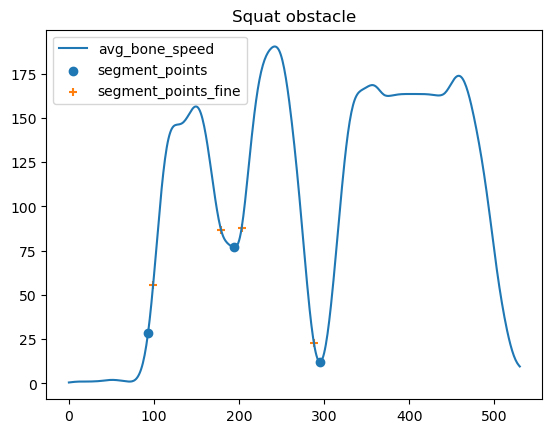

[599, 715, 828, 944, 1060]
[599, 715, 717, 822, 837, 944, 944, 1044]


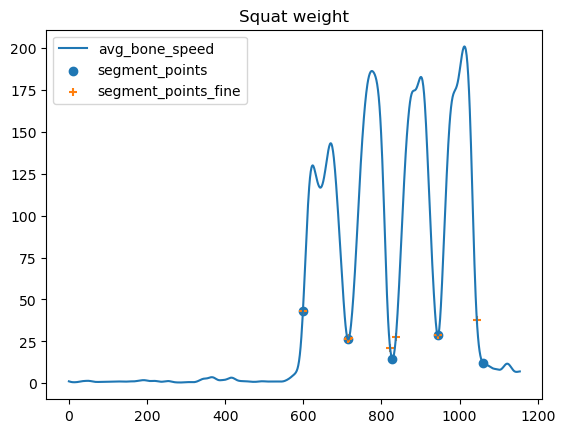

In [102]:
fileTestData = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Test data/All data/test_data_subj20.csv"
output_cols = lat.COLS_TRAINING_DATA

with open(fileTestData, "w") as file:
    file.write(",".join(output_cols))
    file.write("\n")

for fileTuple in filesToRead:
    # Unpack
    activity, fileAllTraj, fileMOTNorm, fileIMUFeat, fileGONFeat, fileEMGFeat, fileModOut = fileTuple
    
    df_mot = pd.read_csv(fileMOTNorm)
    df_imu = pd.read_csv(fileIMUFeat)
    df_gon = pd.read_csv(fileGONFeat)
    df_emg = pd.read_csv(fileEMGFeat)

    arr_mot = df_mot.to_numpy()
    arr_imu = df_imu.to_numpy()
    arr_gon = df_gon.to_numpy()
    arr_emg = df_emg.to_numpy()

    arr_mot = lat.expand_data(arr_mot, 5, 5, crop=True)
    arr_imu = lat.expand_data(arr_imu, 5, 5, crop=True)
    arr_gon = lat.expand_data(arr_gon, 5, 5, crop=True)
    arr_emg = lat.expand_data(arr_emg, 5, 5, crop=True)
    
    # Process differently depending on type of activity (cyclic, stationary, transitional, combination)
    
    if activity in lat.SA_TEST: # Static
        lat.append_static_data(fileTestData, activity, arr_mot, arr_imu, arr_gon, arr_emg)

    elif activity in lat.TA_TEST: # Transitional
        # Read extra data for segmentation
        df_mod_out = pd.read_csv(fileModOut)
        
        arr_bones = df_mod_out[lat.COLS_BONES].to_numpy()
        if instrumented_leg == "left":
            arr_powers = df_mod_out[["LAnklePowerZ", "LKneePowerZ", "LHipPowerZ"]].to_numpy()
        elif instrumented_leg == "right":
            arr_powers = df_mod_out[["RAnklePowerZ", "RKneePowerZ", "RHipPowerZ"]].to_numpy()
        else:
            raise ValueError("Please define 'instrumented_leg' as 'left' or 'right'.")

        arr_bones = arr_bones[20:, :] # Also crop
        arr_powers = arr_powers[20:, :]

        # Append
        lat.append_transitional_data(fileTestData, activity, arr_bones, arr_powers, arr_mot, arr_imu, arr_gon, arr_emg)
    
    elif (activity in lat.SRA_TEST) or (activity in lat.ARA_TEST): # Cyclic
        # Read extra data for segmentation
        df_markers = pd.read_csv(fileAllTraj)
        arr_foot_markers = df_markers[lat.R_FOOT_MARKERS].to_numpy()
        arr_foot_markers = arr_foot_markers[20:, :] # Also crop

        # Append
        lat.append_cyclic_data(fileTestData, activity, arr_foot_markers, arr_mot, arr_imu, arr_gon, arr_emg)

    elif activity in lat.COMBINATIONS: # Combination
        lat.append_combination_data(fileTestData, activity, arr_mot, arr_imu, arr_gon, arr_emg)

### 4) Make different versions of the test data

In [103]:
# Light version with insole data (no individual channels) and data from IMU on thigh, for 0, 100 and 200ms delay
fileTestData = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Test data/All data/test_data_subj20.csv"
newFileTestData = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Test data/LR insole light - LR thigh IMU - 100ms 200ms/test_data_subj20.csv"

data_to_keep = ["Label", "GaitPhase", "GaitSpeed", "NewFile", 
                      
                "LTOTF", "LCOPX", "LCOPY", "RTOTF", "RCOPX", "RCOPY", 
                "LACCX", "LACCY", "LACCZ", "LANGX", "LANGY", "LANGZ", 
                "RACCX", "RACCY", "RACCZ", "RANGX", "RANGY", "RANGZ", 
                "LTOTF 100ms", "LCOPX 100ms", "LCOPY 100ms", "RTOTF 100ms", "RCOPX 100ms", "RCOPY 100ms", 
                "LACCX 100ms", "LACCY 100ms", "LACCZ 100ms", "LANGX 100ms", "LANGY 100ms", "LANGZ 100ms", 
                "RACCX 100ms", "RACCY 100ms", "RACCZ 100ms", "RANGX 100ms", "RANGY 100ms", "RANGZ 100ms", 
                "LTOTF 200ms", "LCOPX 200ms", "LCOPY 200ms", "RTOTF 200ms", "RCOPX 200ms", "RCOPY 200ms", 
                "LACCX 200ms", "LACCY 200ms", "LACCZ 200ms", "LANGX 200ms", "LANGY 200ms", "LANGZ 200ms", 
                "RACCX 200ms", "RACCY 200ms", "RACCZ 200ms", "RANGX 200ms", "RANGY 200ms", "RANGZ 200ms", 
                      
                "L_Femur_DRX", "L_Femur_DRY", "L_Femur_DRZ", "L_Femur_DDTX", "L_Femur_DDTY", "L_Femur_DDTZ", 
                "R_Femur_DRX", "R_Femur_DRY", "R_Femur_DRZ", "R_Femur_DDTX", "R_Femur_DDTY", "R_Femur_DDTZ",
                "L_Femur_DRX 100ms", "L_Femur_DRY 100ms", "L_Femur_DRZ 100ms", "L_Femur_DDTX 100ms", "L_Femur_DDTY 100ms", "L_Femur_DDTZ 100ms",  
                "R_Femur_DRX 100ms", "R_Femur_DRY 100ms", "R_Femur_DRZ 100ms", "R_Femur_DDTX 100ms", "R_Femur_DDTY 100ms", "R_Femur_DDTZ 100ms", 
                "L_Femur_DRX 200ms", "L_Femur_DRY 200ms", "L_Femur_DRZ 200ms", "L_Femur_DDTX 200ms", "L_Femur_DDTY 200ms", "L_Femur_DDTZ 200ms", 
                "R_Femur_DRX 200ms", "R_Femur_DRY 200ms", "R_Femur_DRZ 200ms", "R_Femur_DDTX 200ms", "R_Femur_DDTY 200ms", "R_Femur_DDTZ 200ms"]

df_test_data = pd.read_csv(fileTestData)
df_test_data_light = df_test_data[data_to_keep]
df_test_data_light.to_csv(newFileTestData, index=False)

In [104]:
# Light version with insole data (no individual channels) and data from IMU on thigh, for 0, 100 and 200ms delay
fileTestData = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Test data/All data/test_data_subj20.csv"
newFileTestData = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Test data/LR insole light - R thigh IMU - 100ms 200ms/test_data_subj20.csv"

data_to_keep = ["Label", "GaitPhase", "GaitSpeed", "NewFile", 
                      
                "LTOTF", "LCOPX", "LCOPY", "RTOTF", "RCOPX", "RCOPY", 
                "LACCX", "LACCY", "LACCZ", "LANGX", "LANGY", "LANGZ", 
                "RACCX", "RACCY", "RACCZ", "RANGX", "RANGY", "RANGZ", 
                "LTOTF 100ms", "LCOPX 100ms", "LCOPY 100ms", "RTOTF 100ms", "RCOPX 100ms", "RCOPY 100ms", 
                "LACCX 100ms", "LACCY 100ms", "LACCZ 100ms", "LANGX 100ms", "LANGY 100ms", "LANGZ 100ms", 
                "RACCX 100ms", "RACCY 100ms", "RACCZ 100ms", "RANGX 100ms", "RANGY 100ms", "RANGZ 100ms", 
                "LTOTF 200ms", "LCOPX 200ms", "LCOPY 200ms", "RTOTF 200ms", "RCOPX 200ms", "RCOPY 200ms", 
                "LACCX 200ms", "LACCY 200ms", "LACCZ 200ms", "LANGX 200ms", "LANGY 200ms", "LANGZ 200ms", 
                "RACCX 200ms", "RACCY 200ms", "RACCZ 200ms", "RANGX 200ms", "RANGY 200ms", "RANGZ 200ms", 
                       
                "R_Femur_DRX", "R_Femur_DRY", "R_Femur_DRZ", "R_Femur_DDTX", "R_Femur_DDTY", "R_Femur_DDTZ",
                "R_Femur_DRX 100ms", "R_Femur_DRY 100ms", "R_Femur_DRZ 100ms", "R_Femur_DDTX 100ms", "R_Femur_DDTY 100ms", "R_Femur_DDTZ 100ms", 
                "R_Femur_DRX 200ms", "R_Femur_DRY 200ms", "R_Femur_DRZ 200ms", "R_Femur_DDTX 200ms", "R_Femur_DDTY 200ms", "R_Femur_DDTZ 200ms"]

df_test_data = pd.read_csv(fileTestData)
df_test_data_light = df_test_data[data_to_keep]
df_test_data_light.to_csv(newFileTestData, index=False)

In [105]:
# Light version with insole data (no individual channels) and data from IMU on thigh, for 0, 100 and 200ms delay
fileTestData = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Test data/All data/test_data_subj20.csv"
newFileTestData = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Test data/R insole light - R thigh IMU - 100ms 200ms/test_data_subj20.csv"

data_to_keep = ["Label", "GaitPhase", "GaitSpeed", "NewFile", 
                      
                "RTOTF", "RCOPX", "RCOPY", 
                "RACCX", "RACCY", "RACCZ", "RANGX", "RANGY", "RANGZ", 
                "RTOTF 100ms", "RCOPX 100ms", "RCOPY 100ms", 
                "RACCX 100ms", "RACCY 100ms", "RACCZ 100ms", "RANGX 100ms", "RANGY 100ms", "RANGZ 100ms", 
                "RTOTF 200ms", "RCOPX 200ms", "RCOPY 200ms", 
                "RACCX 200ms", "RACCY 200ms", "RACCZ 200ms", "RANGX 200ms", "RANGY 200ms", "RANGZ 200ms", 
                       
                "R_Femur_DRX", "R_Femur_DRY", "R_Femur_DRZ", "R_Femur_DDTX", "R_Femur_DDTY", "R_Femur_DDTZ",
                "R_Femur_DRX 100ms", "R_Femur_DRY 100ms", "R_Femur_DRZ 100ms", "R_Femur_DDTX 100ms", "R_Femur_DDTY 100ms", "R_Femur_DDTZ 100ms", 
                "R_Femur_DRX 200ms", "R_Femur_DRY 200ms", "R_Femur_DRZ 200ms", "R_Femur_DDTX 200ms", "R_Femur_DDTY 200ms", "R_Femur_DDTZ 200ms"]

df_test_data = pd.read_csv(fileTestData)
df_test_data_light = df_test_data[data_to_keep]
df_test_data_light.to_csv(newFileTestData, index=False)